In [1]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import tushare as ts
import datetime
import time
import matplotlib.pyplot as plt
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [39]:
#settings
work_path = os.path.dirname(os.getcwd())
current_time = time.strftime("%Y%m%d%H%M", time.localtime())
exp_name = 'strategy_1' #策略名
factor_file_path = work_path + '\\backtest\\strategy_file\\%s.csv' %exp_name #策略文件名，保存的三列名称为option_name,trade_time,position
exp_name = exp_name + '_'+ current_time
save_path = work_path + '\\backtest\%s' %exp_name
os.mkdir(save_path)

In [41]:
#ifind_data_format
pd.read_csv(work_path + '\\03_data\\300etf_option2208.csv',index_col = 0)

,time,thscode,open,high,low,close,volume,option_code,maturity_date,type
0,2022-06-23 09:35,10004359.SH,0.3915,0.4250,0.3915,0.4250,3.0,510300C2208M03900,2022-08-24 15:30:00,C
1,2022-06-23 09:40,10004359.SH,0.4300,0.4300,0.4300,0.4300,1.0,510300C2208M03900,2022-08-24 15:30:00,C
2,2022-06-23 09:45,10004359.SH,0.4300,0.4300,0.4300,0.4300,0.0,510300C2208M03900,2022-08-24 15:30:00,C
3,2022-06-23 09:50,10004359.SH,0.4267,0.4267,0.4267,0.4267,10.0,510300C2208M03900,2022-08-24 15:30:00,C
4,2022-06-23 09:55,10004359.SH,0.4255,0.4255,0.4255,0.4255,1.0,510300C2208M03900,2022-08-24 15:30:00,C
...,...,...,...,...,...,...,...,...,...,...
23851,2022-07-25 14:40,10004394.SH,0.6369,0.6369,0.6369,0.6369,0.0,510300P2208M04900,2022-08-24 15:30:00,P
23852,2022-07-25 14:45,10004394.SH,0.6369,0.6369,0.6369,0.6369,0.0,510300P2208M04900,2022-08-24 15:30:00,P
23853,2022-07-25 14:50,10004394.SH,0.6369,0.6369,0.6369,0.6369,0.0,510300P2208M04900,2022-08-24 15:30:00,P
23854,2022-07-25 14:55,10004394.SH,0.6310,0.6310,0.6310,0.6310,6.0,510300P2208M04900,2022-08-24 15:30:00,P


In [42]:
#strategy data_format
pd.read_csv(factor_file_path,index_col = 0)

,option_name,trade_time,position
0,10004359.SH,2022-06-23 09:35,0.066286
1,10004359.SH,2022-06-23 09:40,0.048734
2,10004359.SH,2022-06-23 09:45,0.065435
3,10004359.SH,2022-06-23 09:50,0.068279
4,10004359.SH,2022-06-23 09:55,0.034013
...,...,...,...
23851,10004394.SH,2022-07-25 14:40,0.061529
23852,10004394.SH,2022-07-25 14:45,0.050875
23853,10004394.SH,2022-07-25 14:50,0.011888
23854,10004394.SH,2022-07-25 14:55,0.067732


In [73]:
#data_reprocessing for ifind data
data_ifind = pd.read_csv(work_path + '\\03_data\\300etf_option2208.csv',index_col = 0)

data_ifind = data_ifind.rename(columns={'thscode':'option_name','time':'trade_time'})

data_ifind = data_ifind.groupby('option_name').apply(lambda x:x.sort_values(["trade_time",'option_name']))

data_ifind = pd.DataFrame(columns = data_ifind.columns,data = data_ifind.values)

data_ifind['buy_price'] = data_ifind.groupby('option_name').apply(lambda x:(x.close.shift(1))).values

data_ifind['ret'] = data_ifind.groupby(['option_name']).apply(lambda x:x.close.pct_change()).values

position_data = pd.read_csv(factor_file_path,index_col = 0)

bk = pd.merge(position_data,data_ifind,how="left",on=["option_name","trade_time"])
bk['year'] = bk['trade_time'].apply(lambda x:x.split('-')[0])
bk['month'] = bk['trade_time'].apply(lambda x:x.split('-')[1])
bk['day'] = bk['trade_time'].apply(lambda x:x.split('-')[2])
bk['position_diff'] = bk.groupby('option_name')['position'].diff().values
bk['trade_time'] = pd.to_datetime(bk['trade_time'])
bk = bk.dropna()

bk[['close','ret','open']] = bk[['close','ret','open']].applymap(lambda x:float(x))

bk.head()

,option_name,trade_time,position,open,high,low,close,volume,option_code,maturity_date,type,buy_price,ret,year,month,day,position_diff
1,10004359.SH,2022-06-23 09:40:00,0.048734,0.4300,0.43,0.43,0.4300,1,510300C2208M03900,2022-08-24 15:30:00,C,0.425,0.011765,2022,06,23 09:40,-0.017552
2,10004359.SH,2022-06-23 09:45:00,0.065435,0.4300,0.43,0.43,0.4300,0,510300C2208M03900,2022-08-24 15:30:00,C,0.43,0.000000,2022,06,23 09:45,0.016701
3,10004359.SH,2022-06-23 09:50:00,0.068279,0.4267,0.4267,0.4267,0.4267,10,510300C2208M03900,2022-08-24 15:30:00,C,0.43,-0.007674,2022,06,23 09:50,0.002843
4,10004359.SH,2022-06-23 09:55:00,0.034013,0.4255,0.4255,0.4255,0.4255,1,510300C2208M03900,2022-08-24 15:30:00,C,0.4267,-0.002812,2022,06,23 09:55,-0.034266
5,10004359.SH,2022-06-23 10:00:00,0.002169,0.4149,0.4149,0.4149,0.4149,1,510300C2208M03900,2022-08-24 15:30:00,C,0.4255,-0.024912,2022,06,23 10:00,-0.031844


In [74]:
def backtest(df,transaction_cost = 0,initial_capital = 10**6,Period = False):
    time_list = list(df['trade_time'].unique())
    time_list = sorted(time_list)
    backtest = {}
    pnl_tick = []
    ic = []
    pnl_capital = [0,initial_capital]
    tvr_tick = []
    gross_pnl_tick = []
    #print(time_list)
    for t in tqdm(time_list):
        sub_bk = df[df['trade_time']==t]
        sub_bk['transaction_cost'] = transaction_cost*(pnl_capital[-1]*sub_bk["position"] - pnl_capital[-2]*(sub_bk["position"] - \
                                                                sub_bk["position_diff"]))/(10000*sub_bk["buy_price"]*pnl_capital[-1])
        ic.append(sub_bk[['position','ret']].corr().iloc[0,1])
        pnl_capital.append((1+((sub_bk['ret'] - sub_bk['transaction_cost'])*sub_bk['position']).sum())*pnl_capital[-1])
        pnl_tick.append(((sub_bk['ret'] - sub_bk['transaction_cost'])*sub_bk['position']).sum())
        gross_pnl_tick.append((sub_bk['ret']*sub_bk['position']).sum())
        tvr_tick.append((abs((pnl_capital[-1]*sub_bk["position"] - pnl_capital[-2]*(sub_bk["position"] - \
                                                                sub_bk["position_diff"])))/pnl_capital[-1]).sum())
    ir = np.mean(ic)/np.std(ic)
    ic = np.mean(ic)
    temp_df = pd.Series(pnl_tick, index = time_list)
    gross_temp_df = pd.Series(gross_pnl_tick,index = time_list)
    pnl_capital = pd.Series(pnl_capital[2:],index=time_list)
    daily_ret = temp_df.resample('1d').sum()
    annual_ret = daily_ret.mean()*252
    annual_vol = daily_ret.std()*np.sqrt(252)
    pnl = temp_df.cumsum()
    maxdd = (pnl - pnl.cummax()).cummin()

    tvr = pd.Series(tvr_tick,index=time_list).sum()
    win_rate =  df.groupby('trade_time').apply(lambda x:(x['position']*x['ret']>0).sum()/len(x)).mean()


    backtest['long'] = df.loc[bk['position']>0,'position'].mean()
    backtest['short'] = df.loc[bk['position']<0,'position'].mean()
    backtest['ir'] = ir
    backtest['ic'] = ic
    backtest['SR'] = temp_df.mean()/temp_df.std()  #???
    backtest['Annualized_Ret'] = annual_ret
    backtest['Annualized_SR'] = annual_ret/annual_vol
    backtest['Net_Ret'] = temp_df.sum()
    backtest['Gross_Ret'] = gross_temp_df.sum()
    backtest['maxdd'] = maxdd.iloc[-1]
    backtest['tvr'] = tvr
    backtest['win'] = win_rate
    pnl.index = pnl.index.strftime("%Y-%m-%d-%H:%M")
    pnl_capital.index = pnl_capital.index.strftime("%Y-%m-%d-%H:%M")
    maxdd.index = maxdd.index.strftime("%Y-%m-%d-%H:%M")
    res_ts = pd.DataFrame()
    res_ts['cumulative_return'] = pnl
    res_ts['cumulative_capital'] = pnl_capital
    res_ts['maxdd'] = maxdd
    if not Period:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, 'result.png'))
        pd.DataFrame(pd.Series(backtest),columns = ["value"]).to_csv(os.path.join(save_path, 'result.csv'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    else:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, f'{Period}_result.png'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    return backtest,res_ts

In [75]:
#backtest by period, method = {"year","month"}
#can produce result grouped by period
def backtest_period(df,transaction_cost = 0,initial_capital = 10**6,method = 'year'):
    backtest_period = {}
    pnl_period = {}
    if method == "year":
        period_list = df[method].unique()
        backtest_res = df.groupby(method).apply(lambda x:backtest(x,transaction_cost,initial_capital,f"{x.trade_time.iloc[0].year}")[0])
    else:
        period_list = (df['year'] + df['month']).unique()
        backtest_res = df.groupby(["year",method]).apply(lambda x:backtest(x,transaction_cost,initial_capital,\
                                                                  f"{x.trade_time.iloc[0].year}_{x.trade_time.iloc[0].month}")[0])
    for period in period_list:
        if method =="year":
            backtest_period[period] = backtest_res[period]
        else:
            backtest_period[(period[:4],period[4:])] = backtest_res[(period[:4],period[4:])]
    pd.DataFrame(backtest_period).T.to_csv(os.path.join(save_path, f'result_{method}.csv'))
    return

100%|█████████████████████████████████████████████████████████████████████████████| 1103/1103 [00:04<00:00, 229.75it/s]


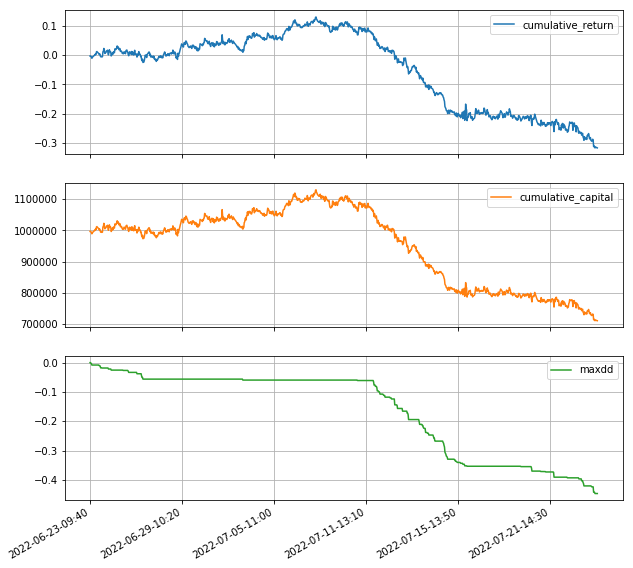

In [76]:
backtest_res,res_ts = backtest(bk,transaction_cost=1.5,initial_capital=10**6)

100%|███████████████████████████████████████████████████████████████████████████████| 816/816 [00:03<00:00, 243.72it/s]


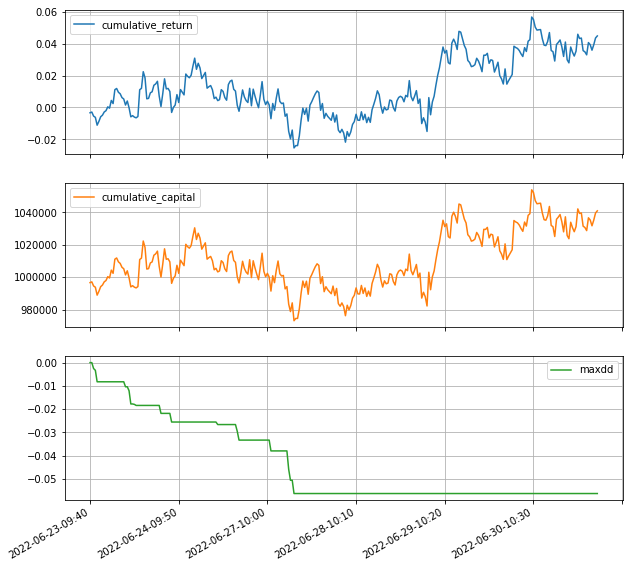

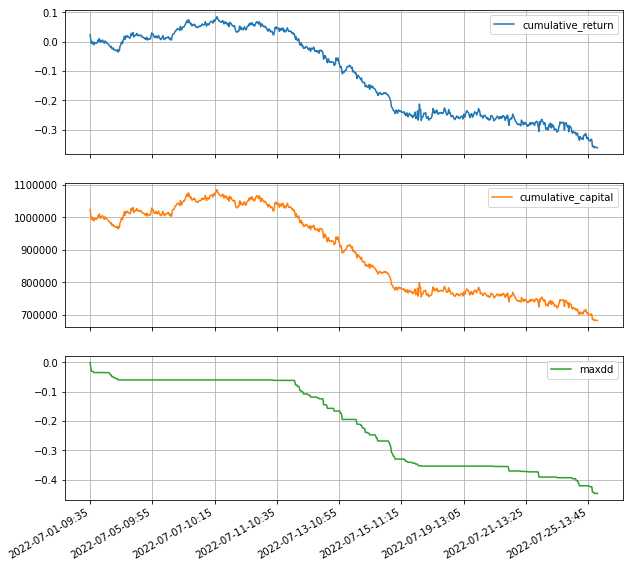

In [77]:
backtest_period(bk,transaction_cost=1.5,initial_capital=10**6,method = "month")